# Mu recovery in 1D LDA

Binary classification with univariate Gaussian conditionals centered at +/- mu (variance 1). We sample data with unbalanced class priors (P(y=0)=0.8, P(y=1)=0.2), fit mu and a shared variance by maximizing the LDA log-likelihood, and compare the learned mu to the true value across settings.


In [1]:
import torch
import matplotlib.pyplot as plt
from src.lda import LDALoss, LogisticLoss

# Reproducible randomness
torch.manual_seed(0)
loss_fn = torch.nn.NLLLoss()
#loss_fn = LDALoss()
#loss_fn = LogisticLoss()


class_priors = torch.tensor([0.5, 0.5])  # P(y=0), P(y=1)


def sample_lda(mu_true: torch.Tensor, n: int = 10000, prior: torch.Tensor = class_priors, sigma2: float = 1.0):
    # Draw n samples from N(+/- mu_true, sigma2) with unbalanced labels from prior.
    prior = prior / prior.sum()
    p1 = float(prior[1])
    y = torch.bernoulli(torch.full((n,), p1)).long()
    means = torch.where(y == 1, mu_true, -mu_true)
    std = torch.full_like(means, sigma2 ** 0.5)
    x = torch.normal(means, std)
    return x, y


def lda_nll(mu_param: torch.Tensor, log_var_param: torch.Tensor, x: torch.Tensor, y: torch.Tensor, prior: torch.Tensor = class_priors):
    # LDA log-likelihood for class means +/- mu_param, shared variance exp(log_var_param), and class priors.
    prior = prior / prior.sum()
    log_prior = prior.clamp_min(1e-8).log()
    var = torch.exp(log_var_param)
    inv_var = 1.0 / var
    logp0 = -0.5 * ((x + mu_param) ** 2) * inv_var - 0.5 * log_var_param
    logp1 = -0.5 * ((x - mu_param) ** 2) * inv_var - 0.5 * log_var_param
    logits = torch.stack([logp0, logp1], dim=1) + log_prior
    return loss_fn(logits, y)


def fit_mu(x: torch.Tensor, y: torch.Tensor, steps: int = 400, lr: float = 0.05, init_mu: float = 0.5, init_log_var: float = 0.0, prior: torch.Tensor = class_priors, train_variance: bool = True):
    mu_hat = torch.nn.Parameter(torch.tensor([init_mu]))
    log_var = torch.nn.Parameter(torch.tensor([init_log_var]))
    params = [mu_hat, log_var] if train_variance else [mu_hat]
    opt = torch.optim.Adam(params, lr=lr)
    for _ in range(steps):
        opt.zero_grad()
        loss = lda_nll(mu_hat, log_var, x, y, prior=prior)
        loss.backward()
        opt.step()
    return mu_hat.detach().item(), torch.exp(log_var).detach().item()


class priors: P(y=0)=0.50, P(y=1)=0.50


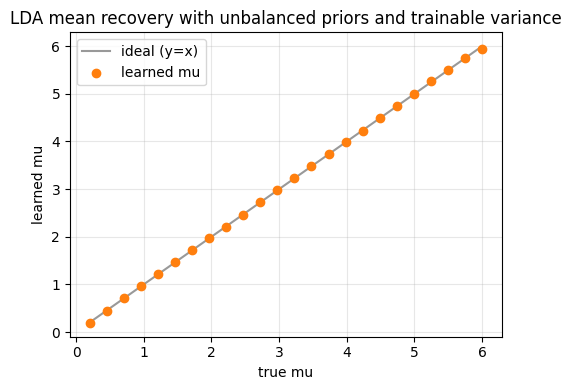

learned variance mean=1.094, std=0.238
true mu=0.20, learned mu=0.192, learned var=1.015
true mu=0.45, learned mu=0.450, learned var=1.010
true mu=0.70, learned mu=0.718, learned var=0.979
true mu=0.96, learned mu=0.966, learned var=1.009
true mu=1.21, learned mu=1.218, learned var=1.013
true mu=1.46, learned mu=1.477, learned var=0.988
true mu=1.71, learned mu=1.719, learned var=0.978
true mu=1.97, learned mu=1.966, learned var=1.009
true mu=2.22, learned mu=2.214, learned var=0.996
true mu=2.47, learned mu=2.466, learned var=0.997
true mu=2.72, learned mu=2.738, learned var=1.010
true mu=2.97, learned mu=2.971, learned var=1.001
true mu=3.23, learned mu=3.223, learned var=0.982
true mu=3.48, learned mu=3.480, learned var=0.987
true mu=3.73, learned mu=3.728, learned var=1.006
true mu=3.98, learned mu=3.987, learned var=0.990
true mu=4.23, learned mu=4.217, learned var=1.003
true mu=4.49, learned mu=4.497, learned var=0.991
true mu=4.74, learned mu=4.749, learned var=1.036
true mu=4.9

In [2]:
mus_true = torch.linspace(0.2, 6, 24)
mu_estimates = []
var_estimates = []

print(f"class priors: P(y=0)={class_priors[0].item():.2f}, P(y=1)={class_priors[1].item():.2f}")

for mu_true in mus_true:
    x, y = sample_lda(mu_true, prior=class_priors)
    mu_hat, var_hat = fit_mu(x, y, prior=class_priors)
    mu_estimates.append(mu_hat)
    var_estimates.append(var_hat)

mu_estimates = torch.tensor(mu_estimates)
var_estimates = torch.tensor(var_estimates)

plt.figure(figsize=(5, 4))
plt.plot(mus_true, mus_true, color='0.6', label='ideal (y=x)')
plt.scatter(mus_true, mu_estimates, color='C1', label='learned mu', zorder=3)
plt.xlabel('true mu')
plt.ylabel('learned mu')
plt.title('LDA mean recovery with unbalanced priors and trainable variance')
plt.grid(alpha=0.3)
plt.legend()
plt.tight_layout()
plt.show()

print(f"learned variance mean={var_estimates.mean():.3f}, std={var_estimates.std(unbiased=False):.3f}")
for t, h, v in zip(mus_true, mu_estimates, var_estimates):
    print(f"true mu={t.item():.2f}, learned mu={h:.3f}, learned var={v:.3f}")
